In [47]:
import json
import matplotlib
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import unicodedata
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, SelectKBest, SelectPercentile, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from pathlib import Path

In [48]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

---

# Lecture

In [49]:
RAW_DATA_PATH = Path("/home/d4gen3/D4GEN/data/raw/raw_dataset_v2.csv")

raw_dataset = pd.read_csv(RAW_DATA_PATH, delimiter=';')

print ('raw_dataset has %i rows and %i columns' % (raw_dataset.shape[0], raw_dataset.shape[1]))

raw_dataset has 1950 rows and 398 columns


---

# Data engineering

## Normalisation de séléction des données

In [50]:
def normalize_column(column_name: str):
    return str(column_name.replace(' ', '_') \
                          .replace('é', 'e') \
                          .replace('à', 'a') \
                          .replace("'", '_').upper())

In [51]:
raw_dataset['Numéro patient'] = raw_dataset['Numéro patient'].astype(int)
prepared_dataset = raw_dataset.set_index('Numéro patient').copy()

# Elimination des lignes/colonnes vides
prepared_dataset = prepared_dataset.dropna(how='all')

# Normalisation des noms des colonnes
for i, c in enumerate(prepared_dataset.columns):
    prepared_dataset = prepared_dataset.rename(columns={c: normalize_column(c)})

# Selection des colonnes intéréssantes
ml_dataset = prepared_dataset[[
    'AGE', 'ATCD_CONSO_ALCOOL', 'ATCD_DIABETE', 'ATCD_FA_CONNU', 'ATCD_HTA', 'BIO_CPK', 'BIO_CRP', 'BIO_POTASSIUM', 'BIO_HBA1C', 'ECPL_BIO_HBA1C', 'BIO_TROPONINE', 'ECPL_ETT_TXT',
    'BIO_TSH3G','ECG_A_L_ARRIVEE', 'BIO_NTPROBNP', 'ECPL_BIO_NTPROBNP', 'ETIO_TOAST', 'FA_SUR_ECGSCOPEHOLTERREVEAL',  'ICI_ASPECT', 'ICI_SWAN_THROMBUS', 
    'NIHSS_INITIAL', 'ICI_IRM_LAC', 'SEXE', 'UNITE_ALCOOL/SEM', 'EC_PAS', 'EC_PAD', 'HISTO_DEFICIT_MOTEUR',  'HISTO_APHASIE', 'ICI_FLAIR_SEQAVC',  'THROMBOLYSE_IV', 
    'THROMBECTOMIE_MECANIQUE', 'BIO_LDL', 'ECPL_BIO_LDL', 'INTUITION_MEDICALE_FA', 'ICI_IRM_NONLAC_D_ACM', 'ICI_IRM_NONLAC_D_ACA', 'ICI_IRM_NONLAC_D_ACP', 'ICI_IRM_NONLAC_D_ACHA', 
    'ICI_IRM_NONLAC_D_IPP', 'ICI_IRM_NONLAC_D_LB', 'ICI_IRM_NONLAC_D_AITC', 'ICI_IRM_NONLAC_D_ACPI', 'ICI_IRM_NONLAC_D_ACAI', 'ICI_IRM_NONLAC_D_ACS', 'ICI_IRM_NONLAC_G_ACM', 'ICI_IRM_NONLAC_G_ACA', 
    'ICI_IRM_NONLAC_G_ACP', 'ICI_IRM_NONLAC_G_ACHA', 'ICI_IRM_NONLAC_G_IPP', 'ICI_IRM_NONLAC_G_LB', 'ICI_IRM_NONLAC_G_AITC', 'ICI_IRM_NONLAC_G_ACPI', 'ICI_IRM_NONLAC_G_ACAI', 'ICI_IRM_NONLAC_G_ACS'
]]

ml_dataset.shape

(1950, 54)

---

## Application des règles métier

In [52]:
# Exclusion des patient ayant une ECG = FA à l'arrivée
FILTER_ECG_ARRIVEE = ml_dataset[ml_dataset['ECG_A_L_ARRIVEE'] == 'Fibrillation/Flutter'].index
ml_dataset = ml_dataset.drop(FILTER_ECG_ARRIVEE)

# Exclusion des patients ayant une étiologie determinée non FA et un antécédent FA connu
FILTER_NON_FA_DETERMINE_ATCD_FA_CONNU = ml_dataset[(ml_dataset['ETIO_TOAST'].isin(['Athérothrombotique', 'Lacunaire', 'Autre cause'])) & (ml_dataset['ATCD_FA_CONNU'] == 'oui')].index
ml_dataset = ml_dataset.drop(FILTER_NON_FA_DETERMINE_ATCD_FA_CONNU)

# Exclusion des patients ayant une étiologie non-determinée, et suite aux examens poussés, une FA non determinée
FILTER_FA_NON_DETERMINE = ml_dataset[(ml_dataset['ETIO_TOAST'].notnull()) & (ml_dataset['ETIO_TOAST'].str.startswith('Indéterminé')) &  (ml_dataset['FA_SUR_ECGSCOPEHOLTERREVEAL'].isna())].index
ml_dataset = ml_dataset.drop(FILTER_FA_NON_DETERMINE)

# Fusion des colonnes complémentaires
ml_dataset['ECPL_BIO_NTPROBNP'].fillna(ml_dataset['BIO_NTPROBNP'], inplace=True)
ml_dataset['ECPL_BIO_LDL'].fillna(ml_dataset['BIO_LDL'], inplace=True)
ml_dataset['ECPL_BIO_HBA1C'].fillna(ml_dataset['BIO_HBA1C'], inplace=True)

# Remplissage des champs vides des colonnes suivantes avec "non"
FILL_WITH_NAN = [ 
    'ICI_IRM_NONLAC_D_ACM', 'ICI_IRM_NONLAC_D_ACA', 'ICI_IRM_NONLAC_D_ACP', 'ICI_IRM_NONLAC_D_ACHA', 
    'ICI_IRM_NONLAC_D_IPP', 'ICI_IRM_NONLAC_D_LB', 'ICI_IRM_NONLAC_D_AITC', 'ICI_IRM_NONLAC_D_ACPI',
    'ICI_IRM_NONLAC_D_ACAI', 'ICI_IRM_NONLAC_D_ACS', 'ICI_IRM_NONLAC_G_ACM', 'ICI_IRM_NONLAC_G_ACA', 
    'ICI_IRM_NONLAC_G_ACP', 'ICI_IRM_NONLAC_G_ACHA', 'ICI_IRM_NONLAC_G_IPP', 'ICI_IRM_NONLAC_G_LB',
    'ICI_IRM_NONLAC_G_AITC', 'ICI_IRM_NONLAC_G_ACPI', 'ICI_IRM_NONLAC_G_ACAI', 'ICI_IRM_NONLAC_G_ACS'
]
for c in FILL_WITH_NAN:
    ml_dataset[c] = ml_dataset[c].fillna('non')

# Indentification des 19 patients ayant une étiologie non-determinée et suite aux examens poussés, 
# une FA trouvée pour l'utiliser dans le test
SET_ETIO_INDETERMINE_FA_POSITIVE_INDEXES = ml_dataset[(ml_dataset['ETIO_TOAST'].notnull()) & (ml_dataset['ETIO_TOAST'].str.startswith('Indéterminé')) &  (ml_dataset['FA_SUR_ECGSCOPEHOLTERREVEAL'] == 1.0)].index

# Supprèssion des colonnes inutisables
ml_dataset = ml_dataset.drop(['ATCD_FA_CONNU', 'ECG_A_L_ARRIVEE', 'BIO_NTPROBNP', 'BIO_LDL', 'BIO_HBA1C'], axis=1)
ml_dataset.shape

(1395, 49)

---

## Encodage des colonnes

In [53]:
# Colonnes catégoriques : Transformation des catégories en valeurs numériques
# Les correspondances categorie-valeur seront sauvegardées dans un dict et enregistré
# ensuite dans un fichier Json

categorical_features = [
    'BIO_CPK', 'BIO_CRP', 'BIO_POTASSIUM', 'BIO_TROPONINE', 'BIO_TSH3G', 'ETIO_TOAST', 'ICI_ASPECT', 
    'ICI_SWAN_THROMBUS', 'ICI_IRM_LAC', 'SEXE', 'ATCD_CONSO_ALCOOL', 'ATCD_DIABETE', 'ATCD_HTA', 'INTUITION_MEDICALE_FA',
    'HISTO_DEFICIT_MOTEUR', 'HISTO_APHASIE', 'ICI_FLAIR_SEQAVC', 'THROMBOLYSE_IV', 'THROMBECTOMIE_MECANIQUE',
    'ICI_IRM_NONLAC_D_ACM', 'ICI_IRM_NONLAC_D_ACA', 'ICI_IRM_NONLAC_D_ACP', 'ICI_IRM_NONLAC_D_ACHA', 
    'ICI_IRM_NONLAC_D_IPP', 'ICI_IRM_NONLAC_D_LB', 'ICI_IRM_NONLAC_D_AITC', 'ICI_IRM_NONLAC_D_ACPI',
    'ICI_IRM_NONLAC_D_ACAI', 'ICI_IRM_NONLAC_D_ACS', 'ICI_IRM_NONLAC_G_ACM', 'ICI_IRM_NONLAC_G_ACA', 
    'ICI_IRM_NONLAC_G_ACP', 'ICI_IRM_NONLAC_G_ACHA', 'ICI_IRM_NONLAC_G_IPP', 'ICI_IRM_NONLAC_G_LB',
    'ICI_IRM_NONLAC_G_AITC', 'ICI_IRM_NONLAC_G_ACPI', 'ICI_IRM_NONLAC_G_ACAI', 'ICI_IRM_NONLAC_G_ACS'
]
mapping_categorical_features_values = dict()
for feature in categorical_features:
    mapping_categorical_features_values[feature] = dict()
    for i, v in enumerate(ml_dataset[feature].unique()):
        if v is None:
            v = "DONNEE_ABSENTE"
        mapping_categorical_features_values[feature][v] = i
        ml_dataset.loc[ml_dataset[feature] == v, feature] = i
        
# *****************************************************************
# *****************************************************************
# Colonnes numériques : Nettoyage des champs et changement de type

numerical_features = [
    'AGE', 'ECPL_BIO_NTPROBNP', 'ICI_ASPECT', 'NIHSS_INITIAL', 'UNITE_ALCOOL/SEM', 'EC_PAS', 'EC_PAD', 'ECPL_BIO_LDL', 'ECPL_BIO_HBA1C'
]
for feature in numerical_features:
    if ml_dataset[feature].dtype == 'object':
        ml_dataset.loc[:, feature] = ml_dataset[feature].str.replace(' ', '').str.replace(',', ".").str.replace('<', '').str.replace('/', '').str.replace('^', '')
        ml_dataset[feature] = ml_dataset[feature].apply(lambda x: '0' if not str(x).isnumeric() else x)
    ml_dataset.loc[:, feature] = pd.to_numeric(ml_dataset[feature])

# *****************************************************************
# *****************************************************************
# Colonnes textuelles : Extraction des Tokens intéréssants (OG DILATE/NON DILATE)
# Récuperation des token via des expression régulière, ensuite encodage

def find_OG_DILATE_NON_DILATE(texte):
    pattern_oui = r"((OG|OREILLETTE GAUCHE)\s+((LIMITE|MODEREMENT|MODEREEMENT|TRES|DISCRETEMENT|PEU|MOYENNE|LEGEREMENT|LIMLITE)\s+)?(DILATE|DILATEE|DILATES|DILATEES)|DILATATION MODEREE DE L'OG|DILATATION IMPOERTANTE DE L'OG|DILATATION DE L'OG|DILATATION OG|DILATATION MODEREE DE L'OREILLETTE GAUCHE|DILATATION MOYENNE DES 2 OREILLETTES|DILATATION MODEREE OG|DILATATION ATRIALE GAUCHE|DILATATION BIATRIALE)\b"
    pattern_non = r"((OG|OREILLETTE GAUCHE)\s+((LIMITE|MODEREMENT)\s+)?NON\s+(DILATE|DILATEE|DILATES|DILATEES)|PAS DE DILATATION DE L'OG|OG EST DE TAILLE NORMALE|OG DE TAILLE NORMALE|OREILLETTES NON DILATEES|OREILLETTES NON DILATEES|OG NORMALE)\b"
    match_oui = re.search(pattern_oui, texte)
    match_non = re.search(pattern_non, texte)
    if match_oui: return 'DILATE'
    if match_non: return 'NON_DILATE'
    return 'ABSENT'

def normalize_ECPL_ETT_TXT(texte):
    if texte is None:
        return None
    texte = re.sub('\s+', ' ', texte)
    return unicodedata.normalize('NFD', texte.upper()).encode('ascii', 'ignore').decode('utf-8')

ml_dataset['ECPL_ETT_TXT'] = ml_dataset['ECPL_ETT_TXT'].astype('str').apply(normalize_ECPL_ETT_TXT)
ml_dataset['OG_ETAT'] = ml_dataset.apply(lambda row: 0 if (find_OG_DILATE_NON_DILATE(row['ECPL_ETT_TXT']) == 'NON_DILATE') 
                                         else 1 if (find_OG_DILATE_NON_DILATE(row['ECPL_ETT_TXT']) == 'DILATE')
                                         else 2, axis=1)
ml_dataset = ml_dataset.drop('ECPL_ETT_TXT', axis=1)

# *****************************************************************
# *****************************************************************
# Colonne cible : Renommage des colonnes et remplissage des champs vides

# ml_dataset = ml_dataset.dropna(subset=['__TARGET__'])
ml_dataset['__TARGET__'] = ml_dataset['FA_SUR_ECGSCOPEHOLTERREVEAL'].fillna(0).astype('int')
del ml_dataset['FA_SUR_ECGSCOPEHOLTERREVEAL']

---

## Split du dataset (Train / Test)

In [54]:
# Indentifiés en haut : 19 patients ayant une étiologie non-determinée et suite aux examens poussés, 
# une FA trouvée pour l'utiliser dans le test
set_etio_indetermine_fa_positive_df = ml_dataset.loc[SET_ETIO_INDETERMINE_FA_POSITIVE_INDEXES].copy()
ml_dataset = ml_dataset.drop(SET_ETIO_INDETERMINE_FA_POSITIVE_INDEXES)

y_set_etio_indetermine_fa_positive_df = set_etio_indetermine_fa_positive_df['__TARGET__']
X_set_etio_indetermine_fa_positive_df = set_etio_indetermine_fa_positive_df.drop('__TARGET__', axis=1)

In [55]:
X = ml_dataset.drop(columns=['__TARGET__'])
y = ml_dataset['__TARGET__']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print ('- Train set : %i rows, %i columns' % (X_train.shape[0], X_train.shape[1]))
print ('- Test set : %i rows, %i columns' % (X_test.shape[0], X_test.shape[1]))

- Train set : 968 rows, 48 columns
- Test set : 416 rows, 48 columns


---

## Valeurs manquantes

In [56]:
impute_when_missing = [
    {'feature': 'ICI_IRM_NONLAC_G_AITC', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_G_ACHA', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_G_IPP', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_G_ACPI', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_D_AITC', 'impute_with': 'MEAN'}, 
    {'feature': 'HISTO_APHASIE', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['HISTO_APHASIE']['non']},
    {'feature': 'ICI_ASPECT', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_D_ACHA', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_D_ACPI', 'impute_with': 'MEAN'}, 
    {'feature': 'BIO_TROPONINE', 'impute_with': 'KNN'},
    {'feature': 'BIO_TSH3G', 'impute_with': 'KNN'}, 
    {'feature': 'NIHSS_INITIAL', 'impute_with': 'MEAN'},
    {'feature': 'THROMBECTOMIE_MECANIQUE', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['THROMBECTOMIE_MECANIQUE']['non']},
    {'feature': 'ICI_IRM_NONLAC_D_ACM', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['ICI_IRM_NONLAC_D_ACM']['non']},
    {'feature': 'ICI_IRM_NONLAC_D_LB', 'impute_with': 'MEAN'}, 
    {'feature': 'BIO_CPK', 'impute_with': 'KNN'}, 
    {'feature': 'UNITE_ALCOOL/SEM', 'impute_with': 'COMPUTE_UNITE_ALCOOL'},
    {'feature': 'BIO_CRP', 'impute_with': 'KNN'}, 
    {'feature': 'SEXE', 'impute_with': 'MEAN'}, 
    {'feature': 'THROMBOLYSE_IV', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['THROMBOLYSE_IV']['non']},
    {'feature': 'ICI_IRM_NONLAC_G_ACM', 'impute_with': 'MEAN'},
    {'feature': 'ECPL_BIO_LDL', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_G_ACP', 'impute_with': 'MEAN'},
    {'feature': 'ATCD_CONSO_ALCOOL', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['ATCD_CONSO_ALCOOL']['Jamais']},
    {'feature': 'ICI_IRM_NONLAC_D_ACA', 'impute_with': 'MEAN'}, 
    {'feature': 'AGE', 'impute_with': 'KNN'}, 
    {'feature': 'ICI_IRM_NONLAC_G_ACS', 'impute_with': 'MEAN'}, 
    {'feature': 'ATCD_DIABETE', 'impute_with': 'COMPUTE_DIABETE'}, 
    {'feature': 'ICI_IRM_LAC', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['ICI_IRM_LAC']['non']},
    {'feature': 'OG_ETAT', 'impute_with': 'MEAN'},
    {'feature': 'ECPL_BIO_HBA1C', 'impute_with': 'MEAN'}, 
    {'feature': 'BIO_POTASSIUM', 'impute_with': 'KNN'}, 
    {'feature': 'ICI_IRM_NONLAC_D_ACS', 'impute_with': 'MEAN'},
    {'feature': 'ICI_IRM_NONLAC_G_ACA', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_IRM_NONLAC_D_ACP', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_FLAIR_SEQAVC', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['ICI_FLAIR_SEQAVC']['non']},
    {'feature': 'ICI_IRM_NONLAC_D_IPP', 'impute_with': 'MEAN'},
    {'feature': 'ICI_IRM_NONLAC_G_ACAI', 'impute_with': 'MEAN'}, 
    {'feature': 'ICI_SWAN_THROMBUS', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['ICI_SWAN_THROMBUS']['non']},
    {'feature': 'ICI_IRM_NONLAC_G_LB', 'impute_with': 'MEAN'}, 
    {'feature': 'HISTO_DEFICIT_MOTEUR', 'impute_with': 'CONSTANT', 'value': mapping_categorical_features_values['HISTO_DEFICIT_MOTEUR']['non']},
    {'feature': 'ICI_IRM_NONLAC_D_ACAI', 'impute_with': 'MEAN'},
    {'feature': 'ATCD_HTA', 'impute_with': 'COMPUTE_HTA'},
    {'feature': 'ECPL_BIO_NTPROBNP', 'impute_with': 'MEAN'}, 
    {'feature': 'ETIO_TOAST', 'impute_with': 'CONSTANT', 'value': ml_dataset['ETIO_TOAST'].nunique() + 1},
]

# Colonnes pour lesquelles les champs seront remplis par KNN
KNN_COLUMNS = []

for feature in impute_when_missing:
    if feature['impute_with'] == 'MEAN':
        v = X_train[feature['feature']].mean()
    elif feature['impute_with'] == 'MEDIAN':
        v = X_train[feature['feature']].median()
    elif feature['impute_with'] == 'MODE':
        v = X_train[feature['feature']].value_counts().index[0]
    elif feature['impute_with'] == 'CONSTANT':
        v = feature['value']
    elif feature['impute_with'] == 'COMPUTE_DIABETE': # BIO_HBA1C >= 6.5 <=> ATCD_DIABETE = OUI
        X_train['ATCD_DIABETE'] = X_train.apply(lambda row: mapping_categorical_features_values['ATCD_DIABETE']['oui'] 
                                                if ((row['ECPL_BIO_HBA1C'] >= 6.5)) else mapping_categorical_features_values['ATCD_DIABETE']['non'], axis=1)
        X_test['ATCD_DIABETE'] = X_test.apply(lambda row: mapping_categorical_features_values['ATCD_DIABETE']['oui'] 
                                              if ((row['ECPL_BIO_HBA1C'] >= 6.5)) else mapping_categorical_features_values['ATCD_DIABETE']['non'], axis=1)
        X_set_etio_indetermine_fa_positive_df['ATCD_DIABETE'] = X_set_etio_indetermine_fa_positive_df.apply(lambda row: mapping_categorical_features_values['ATCD_DIABETE']['oui'] 
                                      if ((row['ECPL_BIO_HBA1C'] >= 6.5)) else mapping_categorical_features_values['ATCD_DIABETE']['non'], axis=1)
        continue
    elif feature['impute_with'] == 'COMPUTE_HTA': # EC_PAS >= 6.5 ||  EC_PAD >= 90 <=> ATCD_HTA = OUI
        X_train['ATCD_HTA'] = X_train.apply(lambda row: mapping_categorical_features_values['ATCD_HTA']['oui'] 
                                            if ((row['EC_PAS'] >= 140.) or (row['EC_PAD'] >= 90.)) else mapping_categorical_features_values['ATCD_HTA']['non'], axis=1)
        X_test['ATCD_HTA'] = X_test.apply(lambda row: mapping_categorical_features_values['ATCD_HTA']['oui'] 
                                          if ((row['EC_PAS'] >= 140.) or (row['EC_PAD'] >= 90.)) else mapping_categorical_features_values['ATCD_HTA']['non'], axis=1)
        X_set_etio_indetermine_fa_positive_df['ATCD_HTA'] = X_set_etio_indetermine_fa_positive_df.apply(lambda row: mapping_categorical_features_values['ATCD_HTA']['oui'] 
                                          if ((row['EC_PAS'] >= 140.) or (row['EC_PAD'] >= 90.)) else mapping_categorical_features_values['ATCD_HTA']['non'], axis=1)
        continue
    elif feature['impute_with'] == 'COMPUTE_UNITE_ALCOOL': # UNITE_ALCOOL/SEM > 21. (Règle métier) => 1 
        X_train['UNITE_ALCOOL/SEM'] = X_train['UNITE_ALCOOL/SEM'].apply(lambda x: int(x >= 21.))
        X_test['UNITE_ALCOOL/SEM'] = X_test['UNITE_ALCOOL/SEM'].apply(lambda x: int(x >= 21.))
        X_set_etio_indetermine_fa_positive_df['UNITE_ALCOOL/SEM'] = X_set_etio_indetermine_fa_positive_df['UNITE_ALCOOL/SEM'].apply(lambda x: int(x >= 21.))
        continue
    elif feature['impute_with'] == 'KNN':
        KNN_COLUMNS.append(feature['feature'])
        continue
        
    X_train[feature['feature']] = X_train[feature['feature']].fillna(v)
    X_test[feature['feature']] = X_test[feature['feature']].fillna(v)
    X_set_etio_indetermine_fa_positive_df[feature['feature']] = X_set_etio_indetermine_fa_positive_df[feature['feature']].fillna(v)
    print ('Imputed missing values in feature %s with value %s' % (feature['feature'], v))

# *****************************************************************
# *****************************************************************

# Supprèssion des colonnes utilisées pour remplir les champs
# vides d'autres colonnes
for c in ['EC_PAS', 'EC_PAD']:
    del X_train[c]
    del X_test[c]
    del X_set_etio_indetermine_fa_positive_df[c]

# *****************************************************************
# *****************************************************************

# Remplissage des champs vides par KNN
N_NEIGHBORS = 50
if len(KNN_COLUMNS):
    imputer = KNNImputer(n_neighbors=N_NEIGHBORS)
    X_train_missing_imputed = pd.DataFrame(imputer.fit_transform(X_train[KNN_COLUMNS]), columns=KNN_COLUMNS).set_index(X_train.index)
    X_test_missing_imputed = pd.DataFrame(imputer.fit_transform(X_test[KNN_COLUMNS]), columns=KNN_COLUMNS).set_index(X_test.index)
    X_train.update(X_train_missing_imputed)
    X_test.update(X_test_missing_imputed)

for c in KNN_COLUMNS:
    X_set_etio_indetermine_fa_positive_df = X_set_etio_indetermine_fa_positive_df.fillna(X_train[c].mean())

Imputed missing values in feature ICI_IRM_NONLAC_G_AITC with value 0.012396694214876033
Imputed missing values in feature ICI_IRM_NONLAC_G_ACHA with value 0.03615702479338843
Imputed missing values in feature ICI_IRM_NONLAC_G_IPP with value 0.02066115702479339
Imputed missing values in feature ICI_IRM_NONLAC_G_ACPI with value 0.040289256198347105
Imputed missing values in feature ICI_IRM_NONLAC_D_AITC with value 0.012396694214876033
Imputed missing values in feature HISTO_APHASIE with value 2
Imputed missing values in feature ICI_ASPECT with value 8.48857142857143
Imputed missing values in feature ICI_IRM_NONLAC_D_ACHA with value 0.0371900826446281
Imputed missing values in feature ICI_IRM_NONLAC_D_ACPI with value 0.03925619834710744
Imputed missing values in feature NIHSS_INITIAL with value 5.5472481827622016
Imputed missing values in feature THROMBECTOMIE_MECANIQUE with value 2
Imputed missing values in feature ICI_IRM_NONLAC_D_ACM with value 0
Imputed missing values in feature ICI_I

---

## Gestion des types

In [58]:
X_train.columns

Index(['AGE', 'ATCD_CONSO_ALCOOL', 'ATCD_DIABETE', 'ATCD_HTA', 'BIO_CPK',
       'BIO_CRP', 'BIO_POTASSIUM', 'ECPL_BIO_HBA1C', 'BIO_TROPONINE',
       'BIO_TSH3G', 'ECPL_BIO_NTPROBNP', 'ETIO_TOAST', 'ICI_ASPECT',
       'ICI_SWAN_THROMBUS', 'NIHSS_INITIAL', 'ICI_IRM_LAC', 'SEXE',
       'UNITE_ALCOOL/SEM', 'HISTO_DEFICIT_MOTEUR', 'HISTO_APHASIE',
       'ICI_FLAIR_SEQAVC', 'THROMBOLYSE_IV', 'THROMBECTOMIE_MECANIQUE',
       'ECPL_BIO_LDL', 'INTUITION_MEDICALE_FA', 'ICI_IRM_NONLAC_D_ACM',
       'ICI_IRM_NONLAC_D_ACA', 'ICI_IRM_NONLAC_D_ACP', 'ICI_IRM_NONLAC_D_ACHA',
       'ICI_IRM_NONLAC_D_IPP', 'ICI_IRM_NONLAC_D_LB', 'ICI_IRM_NONLAC_D_AITC',
       'ICI_IRM_NONLAC_D_ACPI', 'ICI_IRM_NONLAC_D_ACAI',
       'ICI_IRM_NONLAC_D_ACS', 'ICI_IRM_NONLAC_G_ACM', 'ICI_IRM_NONLAC_G_ACA',
       'ICI_IRM_NONLAC_G_ACP', 'ICI_IRM_NONLAC_G_ACHA', 'ICI_IRM_NONLAC_G_IPP',
       'ICI_IRM_NONLAC_G_LB', 'ICI_IRM_NONLAC_G_AITC', 'ICI_IRM_NONLAC_G_ACPI',
       'ICI_IRM_NONLAC_G_ACAI', 'ICI_IRM_NONLAC_G_AC

In [57]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
X_set_etio_indetermine_fa_positive_df = X_set_etio_indetermine_fa_positive_df.astype('float64')

---

## Analyse des composantes principales

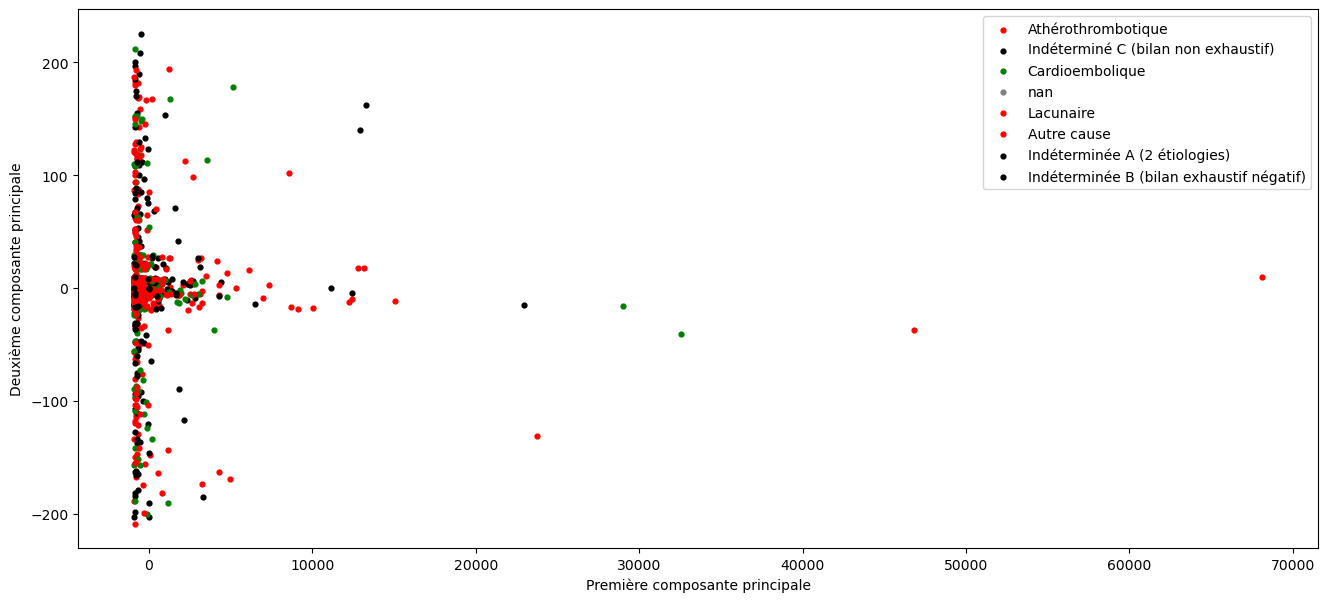

In [12]:
SHOW_INDEXES = False
pca_dataset = pd.concat([X_train.join(pd.DataFrame({'__TARGET__': y_train})), 
                         X_test.join(pd.DataFrame({'__TARGET__': y_test})),
                         X_set_etio_indetermine_fa_positive_df.join(pd.DataFrame({'__TARGET__': y_set_etio_indetermine_fa_positive_df}))], axis=0)

# Appliquer la PCA sur les vecteurs numériques
pca = PCA(n_components=2)
pca = pca.fit_transform(pca_dataset)

# visualiser les résultats de la PCA
pca_df = pd.DataFrame(pca, columns=["PC1", "PC2"])

# Pour colorer les points du graphe
pca_df["ETIO_TOAST"] = pca_dataset["ETIO_TOAST"]
ETIO_TOAST_mapper = {v: k for k, v in mapping_categorical_features_values['ETIO_TOAST'].items()}
colors = {0: "red", 1: "black", 2: "green", 3: "grey", 4: "red", 5: "red", 6: "black", 7: "black"}

# Graphe
fig, ax = plt.subplots(figsize=(16,7))

# Parcourir les étiquettes et les couleurs correspondantes pour colorer les points
for etiology, color in colors.items():
    X = pca_df[pca_df["ETIO_TOAST"] == etiology]["PC1"]
    Y = pca_df[pca_df["ETIO_TOAST"] == etiology]["PC2"]
    ax.scatter(X, Y, c=color, label=ETIO_TOAST_mapper[etiology], s=12)

ax.legend()
plt.xlabel("Première composante principale")
plt.ylabel("Deuxième composante principale")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
if SHOW_INDEXES:
    for i, label in enumerate(X_train.index):
        ax.text(pca[i,0], pca[i,1], label)
plt.show()

## Data augmentation

In [13]:
NUM_SAMPLES = 15
TRANSLATION_RANGE = 0.01
COLUMN_FOR_TRANSLATION = 'AGE'

# Fusionner le dataset d'entrainement et la target
X_train_y_train = X_train.join(y_train)

X_train_positive = X_train_y_train[X_train_y_train['__TARGET__'] == 1.]
X_train_negative = X_train_y_train[X_train_y_train['__TARGET__'] == 0.]

# Duplication des positifs
num_positive = len(X_train_positive)
X_train_positive = pd.concat([X_train_positive]*NUM_SAMPLES, ignore_index=True)

# Translation aléatoire sur certains features séléctionnées
X_train_positive[COLUMN_FOR_TRANSLATION] += np.random.uniform(-TRANSLATION_RANGE, TRANSLATION_RANGE, size=num_positive*NUM_SAMPLES)

# Concaténation des données augmentées
X_train_y_train_augmented = pd.concat([X_train_positive, X_train_negative], ignore_index=True)

# Mélange des données augmentées
X_train_y_train_augmented = X_train_y_train_augmented.sample(frac=1).reset_index(drop=True)

X_train = X_train_y_train_augmented.drop('__TARGET__', axis=1)
y_train = X_train_y_train_augmented['__TARGET__']

print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print('Positifs / Négatifs : ', len(y_train[y_train == 1.]), '/', len(y_train[y_train == 0.]))

X_train shape :  (1836, 46)
y_train shape :  (1836,)
Positifs / Négatifs :  930 / 906


## Remise à l'echelle des colonnes (rescaling)

In [14]:
rescale_features = {
    'ICI_IRM_NONLAC_G_AITC': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_ACHA': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_IPP': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_ACPI': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_AITC': 'AVGSTD', 
    'HISTO_APHASIE': 'AVGSTD', 
    'ICI_ASPECT': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_ACHA': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_ACPI': 'AVGSTD', 
    'BIO_TROPONINE': 'AVGSTD', 
    'BIO_TSH3G': 'AVGSTD', 'NIHSS_INITIAL': 
    'AVGSTD', 'THROMBECTOMIE_MECANIQUE': 
    'AVGSTD', 'ICI_IRM_NONLAC_D_ACM': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_LB': 'AVGSTD', 
    'BIO_CPK': 'AVGSTD', 
    'UNITE_ALCOOL/SEM': 'AVGSTD', 
    'BIO_CRP': 'AVGSTD', 
    'SEXE': 'AVGSTD', 
    'THROMBOLYSE_IV': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_ACM': 'AVGSTD', 
    'ECPL_BIO_LDL': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_ACP': 'AVGSTD', 
    'ATCD_CONSO_ALCOOL': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_ACA': 'AVGSTD', 
    'AGE': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_ACS': 'AVGSTD', 
    'ATCD_DIABETE': 'AVGSTD', 
    'ICI_IRM_LAC': 'AVGSTD', 
    'OG_ETAT': 'AVGSTD', 
    'ECPL_BIO_HBA1C': 'AVGSTD', 
    'BIO_POTASSIUM': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_ACS': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_ACA': 'AVGSTD',
    'ICI_IRM_NONLAC_D_ACP': 'AVGSTD', 
    'ICI_FLAIR_SEQAVC': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_IPP': 'AVGSTD', 
    'ICI_IRM_NONLAC_G_ACAI': 'AVGSTD', 
    'ICI_SWAN_THROMBUS': 'AVGSTD',
    'ICI_IRM_NONLAC_G_LB': 'AVGSTD', 
    'HISTO_DEFICIT_MOTEUR': 'AVGSTD', 
    'ICI_IRM_NONLAC_D_ACAI': 'AVGSTD', 
    'ATCD_HTA': 'AVGSTD', 
    'ECPL_BIO_NTPROBNP': 'AVGSTD',
    'ETIO_TOAST': 'AVGSTD'
}

for (feature_name, rescale_method) in rescale_features.items():
    if rescale_method == 'MINMAX':
        _min = train[feature_name].min()
        _max = train[feature_name].max()
        scale = _max - _min
        shift = _min
    else:
        shift = X_train[feature_name].mean()
        scale = X_train[feature_name].std()
    if scale == 0.:
        del X_train[feature_name]
        del X_test[feature_name]
        print ('Feature %s was dropped because it has no variance' % feature_name)
    else:
        print ('Rescaled %s' % feature_name)
        X_train[feature_name] = (X_train[feature_name] - shift).astype(np.float64) / scale
        X_test[feature_name] = (X_test[feature_name] - shift).astype(np.float64) / scale

Rescaled ICI_IRM_NONLAC_G_AITC
Rescaled ICI_IRM_NONLAC_G_ACHA
Rescaled ICI_IRM_NONLAC_G_IPP
Rescaled ICI_IRM_NONLAC_G_ACPI
Rescaled ICI_IRM_NONLAC_D_AITC
Rescaled HISTO_APHASIE
Rescaled ICI_ASPECT
Rescaled ICI_IRM_NONLAC_D_ACHA
Rescaled ICI_IRM_NONLAC_D_ACPI
Rescaled BIO_TROPONINE
Rescaled BIO_TSH3G
Rescaled NIHSS_INITIAL
Rescaled THROMBECTOMIE_MECANIQUE
Rescaled ICI_IRM_NONLAC_D_ACM
Rescaled ICI_IRM_NONLAC_D_LB
Rescaled BIO_CPK
Rescaled UNITE_ALCOOL/SEM
Rescaled BIO_CRP
Rescaled SEXE
Rescaled THROMBOLYSE_IV
Rescaled ICI_IRM_NONLAC_G_ACM
Rescaled ECPL_BIO_LDL
Rescaled ICI_IRM_NONLAC_G_ACP
Rescaled ATCD_CONSO_ALCOOL
Rescaled ICI_IRM_NONLAC_D_ACA
Rescaled AGE
Rescaled ICI_IRM_NONLAC_G_ACS
Rescaled ATCD_DIABETE
Rescaled ICI_IRM_LAC
Rescaled OG_ETAT
Rescaled ECPL_BIO_HBA1C
Rescaled BIO_POTASSIUM
Rescaled ICI_IRM_NONLAC_D_ACS
Rescaled ICI_IRM_NONLAC_G_ACA
Rescaled ICI_IRM_NONLAC_D_ACP
Rescaled ICI_FLAIR_SEQAVC
Rescaled ICI_IRM_NONLAC_D_IPP
Rescaled ICI_IRM_NONLAC_G_ACAI
Rescaled ICI_SWAN_TH

---

## Sauvegarde des datasets

In [15]:
PREPARED_TRAIN_DATA = Path("/home/d4gen3/D4GEN/data/prepared/train_set.csv")
PREPARED_TEST_DATA = Path("/home/d4gen3/D4GEN/data/prepared/test_set.csv")
PREPARED_DATABASE = Path("/home/d4gen3/D4GEN/data/prepared/prepared_database.csv")
CATEGORICAL_FEATURES_MAPPING = Path("/home/d4gen3/D4GEN/data/prepared/categorical_features_mapping.json")

# Ecriture sur le disque
X_train.join(y_train).to_csv(PREPARED_TRAIN_DATA)
X_test.join(y_test).to_csv(PREPARED_TEST_DATA)
prepared_database = pd.concat([X_train.join(pd.DataFrame({'__TARGET__': y_train})), 
                               X_test.join(pd.DataFrame({'__TARGET__': y_test})),
                               set_etio_indetermine_fa_positive_df], axis=0).to_csv(PREPARED_DATABASE)
with open(CATEGORICAL_FEATURES_MAPPING, "w") as json_outfile:
    json.dump(str(mapping_categorical_features_values), json_outfile)

---

# Modelisation ML

In [16]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_set_etio_indetermine_fa_positive_df = np.array(y_set_etio_indetermine_fa_positive_df)

---

## Random forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=1337,
    min_samples_leaf=3,
    verbose=2
)

%time clf.fit(X_train, y_train)

import pickle
with open('random_forest_model.pickle', 'wb') as file:
    pickle.dump(clf, file)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Cross validation

In [18]:
# accuracy, balanced_accuracy, roc_auc, f1, neg_mean_absolute_error, neg_root_mean_squared_error, r2
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [19]:
scores

array([0.88713911, 0.91282051, 0.8987013 , 0.9250646 , 0.94871795])

In [20]:
scores.mean()

0.9144886934669026

### Results

In [21]:
%time _predictions = clf.predict(X_test)
%time _probas = clf.predict_proba(X_test)
predictions = pd.Series(data=_predictions, index=X_test.index, name='predicted_value')
cols = [
    'probability_of_value_0',
    'probability_of_value_1'
]
probabilities = pd.DataFrame(data=_probas, index=X_test.index, columns=cols)

# Build scored dataset
results_test = X_test.join(predictions, how='left')
results_test = results_test.join(probabilities, how='left')
results_test = results_test.join(pd.DataFrame({'__TARGET__': y_test}), how='left')
results_test = results_test.rename(columns= {'__TARGET__': 'FA_SUR_ECGSCOPEHOLTERREVEAL'})

CPU times: user 13.6 ms, sys: 57 µs, total: 13.7 ms
Wall time: 12.7 ms
CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 10.3 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Features importances

<Axes: title={'center': 'Top 10 most important variables'}, ylabel='feature'>

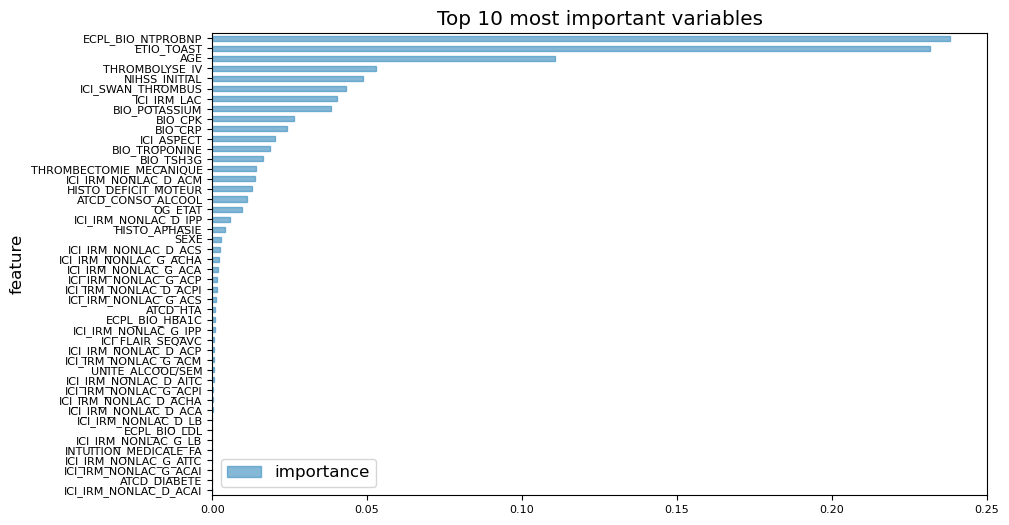

In [22]:
feature_importances_data = []
features = X_train.columns
for feature_name, feature_importance in zip(features, clf.feature_importances_):
    feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# Plot the results
feature_importances_pd = pd.DataFrame(feature_importances_data) \
                                        .set_index('feature') \
                                        .sort_values(by='importance', ascending=True)
    
feature_importances_pd.plot(title='Top 10 most important variables',
          kind='barh',
          figsize=(10, 6),
          color='#348ABD',
          alpha=0.6,
          lw=1.,
          edgecolor='#348ABD',
          grid=False,
        fontsize=8)

## Metrics

### Confusion matrix

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0, 0.5, 'Classe réelle')

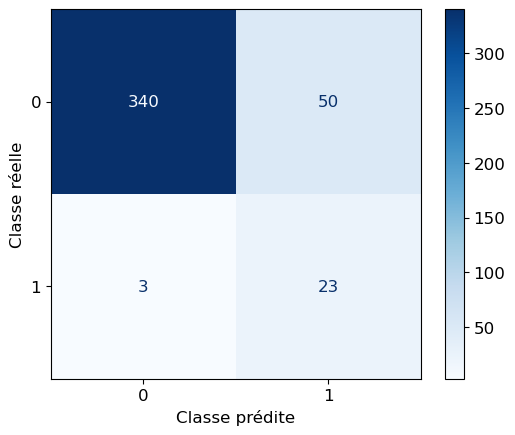

In [23]:
cm_display = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues')
cm_display.ax_.set_xlabel('Classe prédite')
cm_display.ax_.set_ylabel('Classe réelle')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0, 0.5, 'Classe réelle')

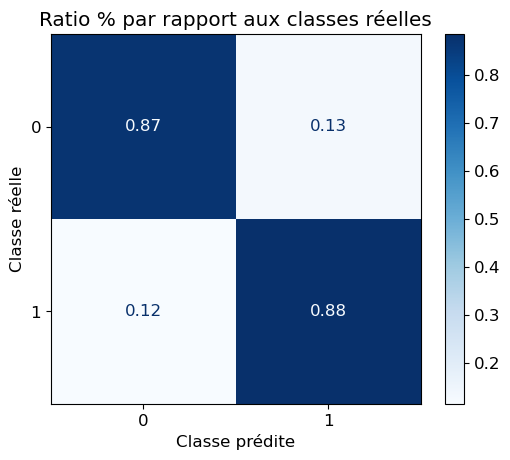

In [24]:
cm_display = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize='true', cmap='Blues', values_format='.2f')
cm_display.ax_.set_title("Ratio % par rapport aux classes réelles")
cm_display.ax_.set_xlabel('Classe prédite')
cm_display.ax_.set_ylabel('Classe réelle')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0, 0.5, 'Classe réelle')

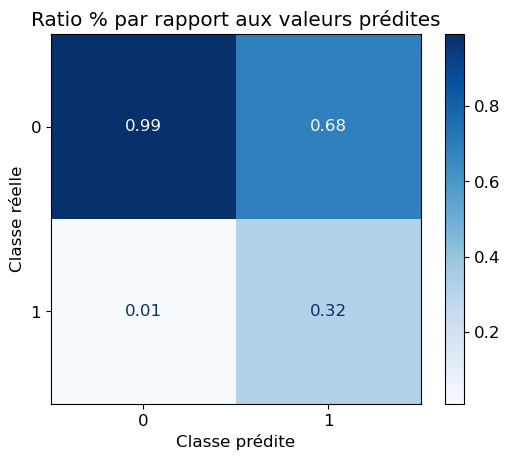

In [25]:
cm_display = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize='pred', cmap='Blues', values_format='.2f')
cm_display.ax_.set_title("Ratio % par rapport aux valeurs prédites")
cm_display.ax_.set_xlabel('Classe prédite')
cm_display.ax_.set_ylabel('Classe réelle')

## Precision Recall curve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


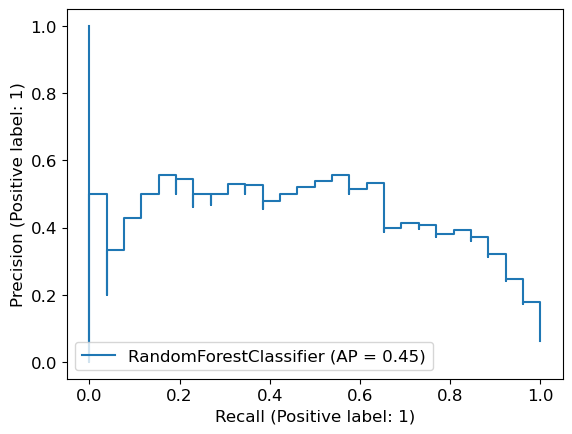

In [26]:
display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

### ROC AUC

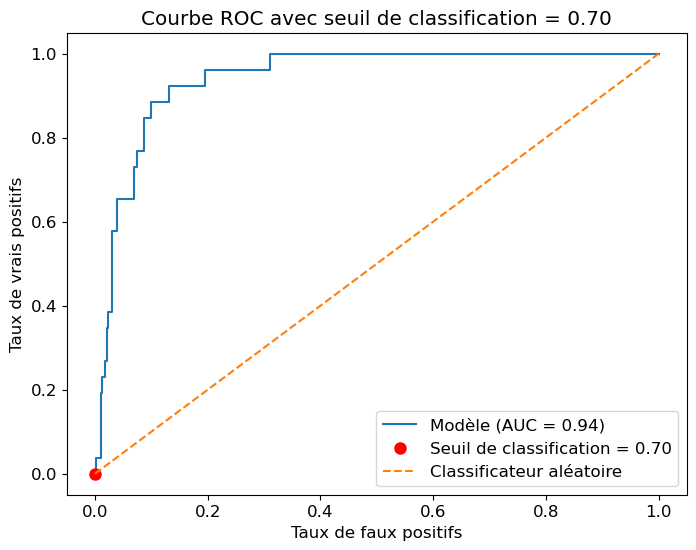

In [27]:
# Définir le seuil de classification
threshold = 0.7

# Calculer les taux de faux positifs et de vrais positifs pour différents seuils de classification
fpr, tpr, thresholds = roc_curve(y_test, _probas[:,1])

# Trouver l'indice du seuil de classification sélectionné
idx = np.argmax(thresholds > threshold)

# Tracer la courbe ROC avec le seuil de classification sélectionné
fig, ax = plt.subplots(figsize=(8, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, _probas[:,1]), estimator_name='Modèle')
roc_display.plot(ax=ax)
ax.plot(fpr[idx], tpr[idx], 'ro', markersize=8, label='Seuil de classification = {:.2f}'.format(threshold))
ax.plot([0, 1], [0, 1], linestyle='--', label='Classificateur aléatoire')
ax.legend()
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC avec seuil de classification = {:.2f}'.format(threshold))
plt.show()

### Treshold optimal

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, _probas[:,1])

# Calculer le critère de Youden pour chaque seuil de classification
youden = tpr - fpr
# Trouver l'indice du seuil de classification optimal
idx = np.argmax(youden)
# Récupérer le seuil de classification optimal
threshold_optimal = thresholds[idx]

print('Seuil de classification optimal:', threshold_optimal)

Seuil de classification optimal: 0.4941532983097533


### Réevaulation du modèle après le calcul du threshold

In [29]:
# Appliquer le seuil de classification optimal aux scores de probabilité
y_pred = (_probas[:,1] >= threshold_optimal).astype(int)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, _predictions)
print('Matrice de confusion:\n', cm)

# Calculer la précision, le rappel et le score F1
precision = precision_score(y_test, _predictions)
recall = recall_score(y_test, _predictions)
f1 = f1_score(y_test, _predictions)
print('Précision:', precision)
print('Rappel:', recall)
print('Score F1:', f1)

# Calculer l'aire sous la courbe ROC
roc_auc = roc_auc_score(y_test, _probas[:,1])
print('ROC AUC:', roc_auc)


Matrice de confusion:
 [[340  50]
 [  3  23]]
Précision: 0.3150684931506849
Rappel: 0.8846153846153846
Score F1: 0.46464646464646464
ROC AUC: 0.942603550295858


### Autres métriques

In [30]:
print('F1 score :', round(f1_score(y_test, predictions), 4))
print('Precision :', round(precision_score(y_test, predictions), 4))
print('Recall :', round(recall_score(y_test, predictions), 4))
print('Mean Squared Error (MSE):', round(mean_squared_error(y_test, predictions), 4))
print('Root Mean Squared Error (RMSE):', round(mean_squared_error(y_test, predictions, squared=False), 4))
print('Mean Absolute Percentage Error (MAPE):', round(mean_absolute_percentage_error(y_test, predictions), 4))
print('Explained Variance Score:', round(explained_variance_score(y_test, predictions), 4))
print('Max Error:', round(max_error(y_test, predictions), 4))
print('Mean Squared Log Error:', round(mean_squared_log_error(y_test, predictions), 4))
print('Median Absolute Error:', round(median_absolute_error(y_test, predictions), 4))
print('R^2:', round(r2_score(y_test, predictions), 4))

F1 score : 0.4646
Precision : 0.3151
Recall : 0.8846
Mean Squared Error (MSE): 0.1274
Root Mean Squared Error (RMSE): 0.3569
Mean Absolute Percentage Error (MAPE): 541298032135876.94
Explained Variance Score: -0.9565
Max Error: 1
Mean Squared Log Error: 0.0612
Median Absolute Error: 0.0
R^2: -1.1744


## Tester avec les patients faisant parti de la classe particulière

In [31]:
%time _predictions = clf.predict(X_set_etio_indetermine_fa_positive_df)
%time _probas = clf.predict_proba(X_set_etio_indetermine_fa_positive_df)
predictions = pd.Series(data=_predictions, index=X_set_etio_indetermine_fa_positive_df.index, name='predicted_value')
cols = [
    'probability_of_value_0',
    'probability_of_value_1'
]
probabilities = pd.DataFrame(data=_probas, index=X_set_etio_indetermine_fa_positive_df.index, columns=cols)

CPU times: user 17.4 ms, sys: 4.27 ms, total: 21.6 ms
Wall time: 17.1 ms
CPU times: user 14.2 ms, sys: 76 µs, total: 14.3 ms
Wall time: 11.7 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
probabilities

,probability_of_value_0,probability_of_value_1
Numéro patient,,
47,0.485271,0.514729
102,0.440077,0.559923
676,0.475439,0.524561
773,0.478325,0.521675
814,0.446368,0.553632
1092,0.455094,0.544906
1180,0.468493,0.531507
1246,0.464767,0.535233
1293,0.454935,0.545065


---

## XGBoost

In [34]:
xgb_model = xgb.XGBClassifier(
                    max_depth=20,
                    learning_rate=0.001,
                    gamma=0.0,
                    min_child_weight=1.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=0.0,
                    reg_lambda=1.0,
                    n_estimators=30,
                    silent=0,
                    nthread=10,
                    scale_pos_weight=1.0,
                    base_score=0.5,
                    seed=1337
                    )

In [35]:
%time xgb_model.fit(X_train, y_train)

[10:13:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

CPU times: user 2.81 s, sys: 28.5 ms, total: 2.83 s
Wall time: 91.4 ms


XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.0, max_depth=20, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=None, nthread=10, num_parallel_tree=None,
              predictor=None, ...)

In [36]:
xgb_predictions = xgb_model.predict(X_test)

In [37]:
%time _xgb_predictions = xgb_model.predict(X_test)
%time _xgb_probas = xgb_model.predict_proba(X_test)
xgb_predictions = pd.Series(data=_xgb_predictions, index=X_test.index, name='predicted_value')
xgb_cols = [
    'probability_of_value_0',
    'probability_of_value_1'
]
xgb_probabilities = pd.DataFrame(data=_xgb_probas, index=X_test.index, columns=xgb_cols)

# Build scored dataset
xgb_results_test = X_test.join(xgb_predictions, how='left')
xgb_results_test = xgb_results_test.join(xgb_probabilities, how='left')
xgb_results_test = xgb_results_test.join(pd.DataFrame({'__TARGET__': y_test}), how='left')
xgb_results_test = xgb_results_test.rename(columns= {'__TARGET__': 'FA_SUR_ECGSCOPEHOLTERREVEAL'})

CPU times: user 108 ms, sys: 3.46 ms, total: 111 ms
Wall time: 3.49 ms
CPU times: user 92.5 ms, sys: 0 ns, total: 92.5 ms
Wall time: 2.9 ms


## Features importances

<Axes: title={'center': 'Top 10 most important variables'}, ylabel='feature'>

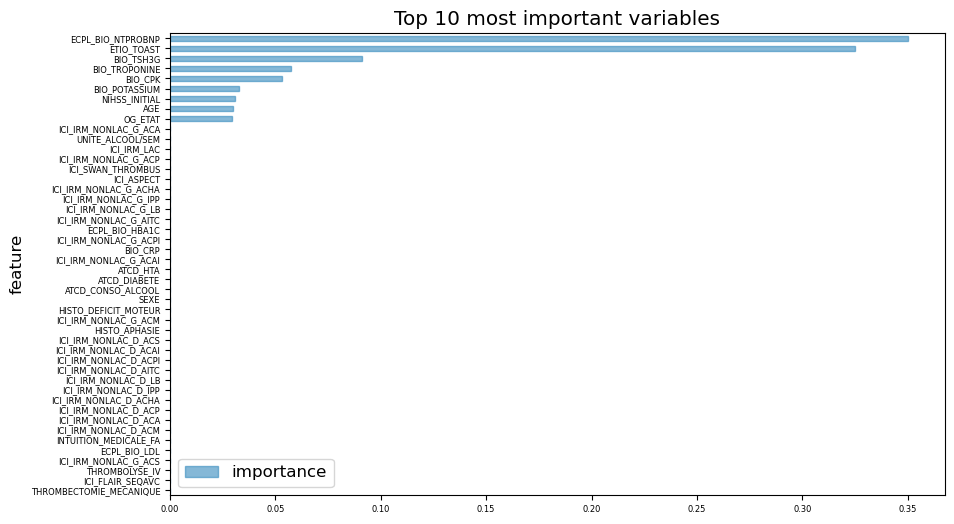

In [38]:
xgb_feature_importances_data = []
features = X_train.columns
for feature_name, feature_importance in zip(features, xgb_model.feature_importances_):
    xgb_feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# Plot the results
pd.DataFrame(xgb_feature_importances_data)\
    .set_index('feature')\
    .sort_values(by='importance', ascending=True) \
    .plot(title='Top 10 most important variables',
          kind='barh',
          figsize=(10, 6),
          color='#348ABD',
          alpha=0.6,
          lw=1.,
          edgecolor='#348ABD',
          grid=False, fontsize=6)

## Metrics

### Confusion matrix

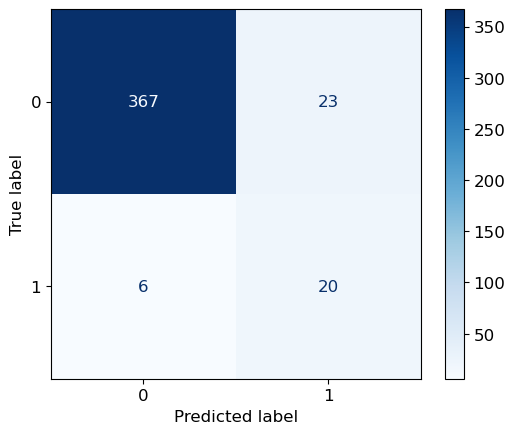

In [39]:
xgb_cm = confusion_matrix(y_test, _xgb_predictions)
ConfusionMatrixDisplay(xgb_cm).plot(cmap='Blues')

Text(0, 0.5, 'Classe réelle')

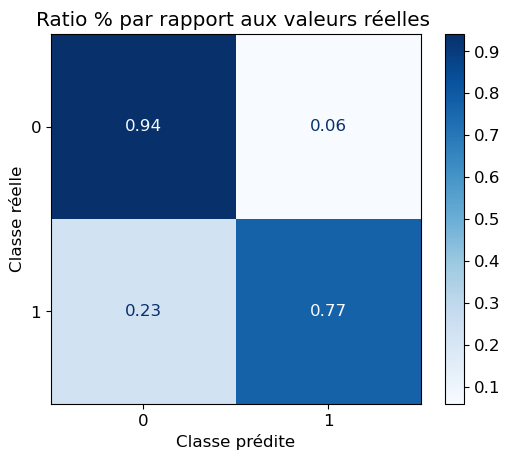

In [40]:
cm_display = ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, normalize='true', cmap='Blues', values_format='.2f')
cm_display.ax_.set_title("Ratio % par rapport aux valeurs réelles ")
cm_display.ax_.set_xlabel('Classe prédite')
cm_display.ax_.set_ylabel('Classe réelle')

Text(0, 0.5, 'Classe réelle')

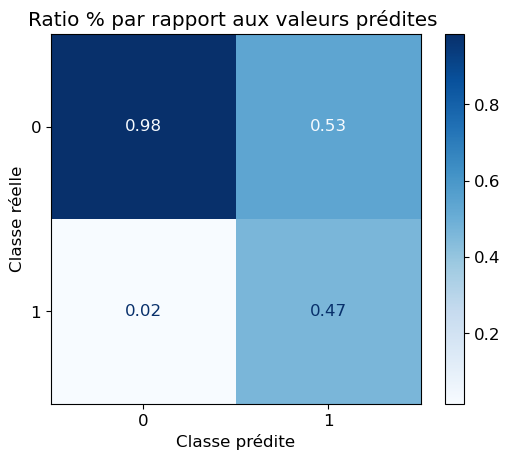

In [41]:
cm_display = ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, normalize='pred', cmap='Blues', values_format='.2f')
cm_display.ax_.set_title("Ratio % par rapport aux valeurs prédites ")
cm_display.ax_.set_xlabel('Classe prédite')
cm_display.ax_.set_ylabel('Classe réelle')

### Precision Recall curve

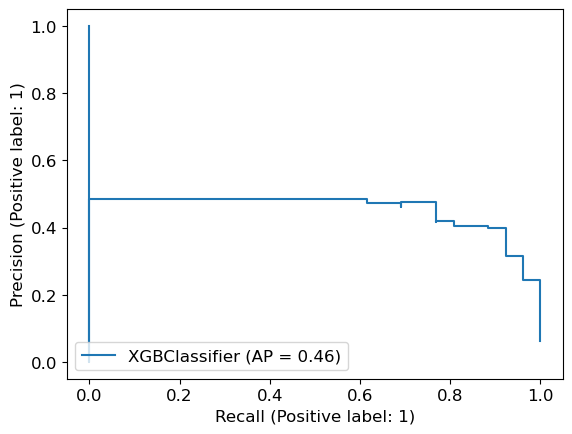

In [42]:
display = PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test)

### Autres métriques

In [43]:
print('F1 score :', round(f1_score(y_test, xgb_predictions), 4))
print('Precision :', round(precision_score(y_test, xgb_predictions), 4))
print('Recall :', round(recall_score(y_test, xgb_predictions), 4))
print('Mean Squared Error (MSE):', round(mean_squared_error(y_test, xgb_predictions), 4))
print('Root Mean Squared Error (RMSE):', round(mean_squared_error(y_test, xgb_predictions, squared=False), 4))
print('Mean Absolute Percentage Error (MAPE):', round(mean_absolute_percentage_error(y_test, xgb_predictions), 4))
print('Explained Variance Score:', round(explained_variance_score(y_test, xgb_predictions), 4))
print('Max Error:', round(max_error(y_test, xgb_predictions), 4))
print('Mean Squared Log Error:', round(mean_squared_log_error(y_test, xgb_predictions), 4))
print('Median Absolute Error:', round(median_absolute_error(y_test, xgb_predictions), 4))
print('R^2:', round(r2_score(y_test, xgb_predictions), 4))

F1 score : 0.5797
Precision : 0.4651
Recall : 0.7692
Mean Squared Error (MSE): 0.0697
Root Mean Squared Error (RMSE): 0.264
Mean Absolute Percentage Error (MAPE): 248997094782503.38
Explained Variance Score: -0.1612
Max Error: 1
Mean Squared Log Error: 0.0335
Median Absolute Error: 0.0
R^2: -0.1897


### Tester avec les patients faisant parti de la classe particulière

In [44]:
%time _xgb_predictions = xgb_model.predict(X_set_etio_indetermine_fa_positive_df)
%time _xgb_probas = xgb_model.predict_proba(X_set_etio_indetermine_fa_positive_df)
xgb_predictions = pd.Series(data=_xgb_predictions, index=X_set_etio_indetermine_fa_positive_df.index, name='predicted_value')
xgb_cols = [
    'probability_of_value_0',
    'probability_of_value_1'
]
xgb_probabilities = pd.DataFrame(data=_xgb_probas, index=X_set_etio_indetermine_fa_positive_df.index, columns=xgb_cols)


CPU times: user 40.2 ms, sys: 0 ns, total: 40.2 ms
Wall time: 3.81 ms
CPU times: user 23.8 ms, sys: 663 µs, total: 24.5 ms
Wall time: 2.37 ms


In [45]:
_xgb_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
xgb_probabilities

,probability_of_value_0,probability_of_value_1
Numéro patient,,
47,0.513843,0.486157
102,0.513843,0.486157
676,0.513843,0.486157
773,0.513843,0.486157
814,0.513843,0.486157
1092,0.513843,0.486157
1180,0.513843,0.486157
1246,0.513843,0.486157
1293,0.513843,0.486157
